# Cohort Analysis with SQL and Python

**Introduction:**

This data analyst portfolio project focuses on performing a cohort analysis of legislator retention using data from past and present members of the US Congress. The objective is to determine how long representatives keep their jobs after taking office.

 <a href="https://github.com/unitedstates/congress-legislators" target="_blank">GitHub repository data set of past and present members of the US Congress</a>.

**Data Description:**

The data includes information on US Congress members from different periods and comprises various attributes such as name, party affiliation, state, and the duration of their tenure in Congress.

**Project Goals:**

The goal of this project is to analyze legislator retention rates and identify any patterns or trends in the data. We aim to measure retention using different metrics and plot retention curves to visualize the trends. Furthermore, we will reshape the data into a table format and analyze retention rates across various groups in the cohort analysis, including retention by century, state, and gender.

**Data Analysis Techniques:**

We will use **SQL** and **Python** techniques for data analysis, including **Window Functions**, **CTE**, and **Date Dimension Tables**. The project will begin with data exploration, followed by demonstrating how to conduct SQL queries on Pandas DataFrames using Python. For **visualization**, we will use libraries such as **Matplotlib**.

**Conclusion and Insights:**

 For a more detailed summary and insights, please refer to the conclusion section of the project.

## 1. Data Exploration

For the analyses, I will use a data set of past and present members of the US Congress located in a <a href="https://github.com/unitedstates/congress-legislators" target="_blank">GitHub repository</a>.

I'll use two tables: **legislators_DF** and **legislators_terms_DF**. We can use pandas.read_csv to read CSV files into DataFrames:

In [1]:
#import libraries
import pandas as pd

#read in the data
legislators_DF =pd.read_csv(r'C:\Rodrigo\Data sets\legislators.csv')
legislators_terms_DF =pd.read_csv(r'C:\Rodrigo\Data sets\legislators_terms.csv')

With the head method we can show samples of the **legislators_terms_DF** and **legislators_DF tables**:

In [2]:
legislators_DF.head(3)

,full_name,first_name,last_name,middle_name,nickname,suffix,other_names_end,other_names_middle,other_names_last,birthday,...,id_house_history_alternate,id_thomas,id_cspan,id_votesmart,id_lis,id_ballotpedia,id_opensecrets,id_fec_0,id_fec_1,id_fec_2
0,Sherrod Brown,Sherrod,Brown,NaN,NaN,NaN,NaN,NaN,NaN,1952-11-09,...,NaN,136.0,5051.0,27018.0,S307,Sherrod Brown,N00003535,H2OH13033,S6OH00163,NaN
1,Maria Cantwell,Maria,Cantwell,NaN,NaN,NaN,NaN,NaN,NaN,1958-10-13,...,NaN,172.0,26137.0,27122.0,S275,Maria Cantwell,N00007836,S8WA00194,H2WA01054,NaN
2,Benjamin L. Cardin,Benjamin,Cardin,L.,NaN,NaN,NaN,NaN,NaN,1943-10-05,...,NaN,174.0,4004.0,26888.0,S308,Ben Cardin,N00001955,H6MD03177,S6MD03177,NaN


In [3]:
legislators_terms_DF.head(3)

,id_bioguide,term_number,term_id,term_type,term_start,term_end,state,district,class,party,how,url,address,phone,fax,contact_form,office,state_rank,rss_url,caucus
0,B000944,0,B000944-0,rep,1993-01-05,1995-01-03,OH,13.0,NaN,Democrat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C000127,0,C000127-0,rep,1993-01-05,1995-01-03,WA,1.0,NaN,Democrat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C000141,0,C000141-0,rep,1987-01-06,1989-01-03,MD,3.0,NaN,Democrat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see in the samples above, the **legislators_DF** table contains a list of all the people included in the data set, with birthday, gender, and a set of ID fields that can be used to look up the person in other data sets. 

The **legislators_terms_DF** table contains a record for each term in office for each legislator, with start and end date, and other attributes such as chamber and party. 

The id_bioguide field is used as the unique identifier of a legislator and appears in each table.

## 2. Performing SQL Queries on Pandas DataFrames Using Python

We can query pandas DataFrames using **SQL syntax**. First we need to install **pandasql** library with the syntax below:

`pip install pandasql`

After successfully installing the library, we are able to import the library using the following statement:


In [4]:
from pandasql import sqldf

## 3. Calculating Retention

### 3.1 Finding the first date each legislator took office:

The first step is to find the first date each legislator took office (first_term). We will use this date to calculate the number of periods for each subsequent date in the time series. To do this, take the min of the term_start and GROUP BY each id_bioguide, the unique identifier for a legislator:

In [5]:
first_date_each_legislator_took_office = """SELECT id_bioguide ,min(term_start) 
as first_term FROM legislators_terms_DF GROUP BY 1"""
df_first_date_each_legislator_took_office = sqldf(first_date_each_legislator_took_office)
df_first_date_each_legislator_took_office.head(3)

,id_bioguide,first_term
0,A000001,1951-01-03
1,A000002,1947-01-03
2,A000003,1817-12-01


### 3.2 Defining the span of time in which the entity is still present:

It’s important to consider data accurately reflects the presence or absence of entities at each time period.

The legislative data set includes records for the start dates of each term, but it lacks information on the number of years a legislator is entitled to serve (two or six years, depending on the chamber).To address this gap, we need to fill in the "missing" values for the years the legislators remain in office between new terms.

To measure retention, we will consider legislators who remained in office until the end of the year on December 31st.

To do this, we can first create **date dimension table**. A **date dimension table** is a static table that has one row for each calendar date, with optional extended date attributes, such as day of the week, month name, end of month, and fiscal year.


#### 3.2.1 Creating a Date Dimension with SQL:

With the following SQL code we can create a **date dimension table** (*df_date_dim*) using a recursive **CTE**. The output of the code below shows a sample of the data in the *df_date_dim* table.

In [6]:
date_dim = """
-- Initiate the recursive loop
WITH RECURSIVE
-- Define a CTE to hold the recursive output
rDateDimensionMinute (CalendarDateInterval)
AS
    (
        -- The anchor of the recursion is the start date of the date dimension
        SELECT datetime('1770-01-01 00:00:00')
        UNION ALL
        -- The recursive query increments the time interval by the desired amount
        -- This can be any time increment (monthly, daily, hours, minutes)
        SELECT datetime(CalendarDateInterval, '+24 hour') FROM rDateDimensionMinute
        -- Set the number of recursions
        -- Functionally, this is the number of periods in the date dimension
        LIMIT 100000
    )
-- Output the result set to the permanent table
SELECT 
    date(CalendarDateInterval) as date,
    datetime(CalendarDateInterval, '+86399 second') CalendarDateIntervalEnd,
    strftime('%w',CalendarDateInterval)	DayNumber,
    case cast (strftime('%w', CalendarDateInterval) as integer)
    when 0 then 'Sunday'
    when 1 then 'Monday'
    when 2 then 'Tuesday'
    when 3 then 'Wednesday'
    when 4 then 'Thursday'
    when 5 then 'Friday'
    when 6 then 'Saturday' end DayOfWeek,
    substr('SunMonTueWedThuFriSat', 1 + 3*strftime('%w', CalendarDateInterval), 3) DayOfWeekAbbr,
    strftime('%d',CalendarDateInterval)	DayOfMonth,
    case cast (strftime('%w', CalendarDateInterval) as integer)
    when 0 then 1
    when 6 then 1
    else 0 end IsWeekend,
    case cast (strftime('%w', CalendarDateInterval) as integer)
    when 0 then 0
    when 6 then 0
    else 1 end IsWeekday,
    strftime('%m',CalendarDateInterval)	MonthNumber,
    case strftime('%m', date(CalendarDateInterval)) 
        when '01' then 'January' 
        when '02' then 'Febuary' 
        when '03' then 'March' 
        when '04' then 'April' 
        when '05' then 'May' 
        when '06' then 'June' 
        when '07' then 'July' 
        when '08' then 'August' 
        when '09' then 'September' 
        when '10' then 'October' 
        when '11' then 'November' 
        when '12' then 'December' else '' end MonthName,
    case strftime('%m', date(CalendarDateInterval)) 
        when '01' then 'Jan' 
        when '02' then 'Feb' 
        when '03' then 'Mar' 
        when '04' then 'Apr' 
        when '05' then 'May' 
        when '06' then 'Jun' 
        when '07' then 'Jul' 
        when '08' then 'Aug' 
        when '09' then 'Sep' 
        when '10' then 'Oct' 
        when '11' then 'Nov' 
        when '12' then 'Dec' else '' end MonthAbbr,
    strftime('%Y',CalendarDateInterval)	YearNumber
FROM rDateDimensionMinute """
df_date_dim = sqldf(date_dim)
df_date_dim.head(4)

,date,CalendarDateIntervalEnd,DayNumber,DayOfWeek,DayOfWeekAbbr,DayOfMonth,IsWeekend,IsWeekday,MonthNumber,MonthName,MonthAbbr,YearNumber
0,1770-01-01,1770-01-01 23:59:59,1,Monday,Mon,01,0,1,01,January,Jan,1770
1,1770-01-02,1770-01-02 23:59:59,2,Tuesday,Tue,02,0,1,01,January,Jan,1770
2,1770-01-03,1770-01-03 23:59:59,3,Wednesday,Wed,03,0,1,01,January,Jan,1770
3,1770-01-04,1770-01-04 23:59:59,4,Thursday,Thu,04,0,1,01,January,Jan,1770


#### 3.2.2 Creating a data set that contains a record for each December 31 that each legislator was in office.

We need to create a data set that contains a record for each December 31 that each legislator was in office.
This can be accomplished by joining the **subquery** that found the first_term to the legislators_terms table to find the term_start and term_end for each term. 
A second JOIN to the **df_date_dim** retrieves the dates that fall between the start and end dates, restricting the returned values to c.month_name ='December' and c.day_of_month = 31. 

The **periods** is calculated as the years between the date from the date_dim and the first_term.


In [7]:
row_for_each_year_end = """
SELECT 
a.id_bioguide, 
a.first_term,
b.term_start, 
b.term_end,
c.date as year_end,
cast(strftime('%Y.%m%d',date(c.date)) - strftime('%Y.%m%d', a.first_term) as int) as periods
FROM
(
        SELECT id_bioguide, min(term_start) as first_term
        FROM legislators_terms_DF 
        GROUP BY 1
) a
JOIN legislators_terms_DF  b on a.id_bioguide = b.id_bioguide 
LEFT JOIN df_date_dim c on c.date between b.term_start and b.term_end 
and c.MonthName = 'December' and c.DayOfMonth = 31
order by a.id_bioguide,cast(strftime('%Y.%m%d',date(c.date)) - strftime('%Y.%m%d', a.first_term) as int)
"""
df_row_for_each_year_end = sqldf(row_for_each_year_end)
df_row_for_each_year_end.head(10)

,id_bioguide,first_term,term_start,term_end,year_end,periods
0,A000001,1951-01-03,1951-01-03,1953-01-03,1951-12-31,0.0
1,A000001,1951-01-03,1951-01-03,1953-01-03,1952-12-31,1.0
2,A000002,1947-01-03,1947-01-03,1949-01-03,1947-12-31,0.0
3,A000002,1947-01-03,1947-01-03,1949-01-03,1948-12-31,1.0
4,A000002,1947-01-03,1949-01-03,1951-01-03,1949-12-31,2.0
5,A000002,1947-01-03,1949-01-03,1951-01-03,1950-12-31,3.0
6,A000002,1947-01-03,1951-01-03,1953-01-03,1951-12-31,4.0
7,A000002,1947-01-03,1951-01-03,1953-01-03,1952-12-31,5.0
8,A000002,1947-01-03,1953-01-03,1955-01-03,1953-12-31,6.0
9,A000002,1947-01-03,1953-01-03,1955-01-03,1954-12-31,7.0


### 3.3 Finding the number of legislators retained in each time period

We now have a row for each date (year end) for which we would like to calculate retention. The next step is to calculate the cohort_retained for each period, which is done with a count of id_bioguide. A **coalesce function** is used on period to set a default value of 0 when null. This handles the cases in which a legislator’s term starts and ends in the same year, giving credit for serving in that year:

In [8]:
number_legislators_retained_by_period = """
SELECT 
coalesce(periods,0) as periods,
count(distinct id_bioguide) as cohort_retained
FROM
df_row_for_each_year_end
GROUP BY 1"""
df_number_legislators_retained_by_period = sqldf(number_legislators_retained_by_period)
df_number_legislators_retained_by_period.head(10)

,periods,cohort_retained
0,0.0,12518
1,1.0,12328
2,2.0,8166
3,3.0,8069
4,4.0,5862
5,5.0,5795
6,6.0,4361
7,7.0,4339
8,8.0,3521
9,9.0,3485


### 3.4 Calculating the percent of legislators retained in each time period

Now that we have the periods and the number of legislators retained in each, the final step is to calculate the total *cohort_size* and populate it in each row so that the cohort_retained can be divided by it. The *first_value* **window function** returns the first record in the PARTITION BY clause, according to the ordering set in the ORDER BY. In this case, the cohort_size comes from the first record in the entire data set, so the PARTITION BY is omitted.

To find the *percent retained*, divide the cohort_retained value by this same calculation:

In [9]:
percent_legislators_retained_by_period="""
SELECT periods, 
cohort_retained, 
first_value(cohort_retained) over (order by periods) as cohort_size, 
cohort_retained* 1.0 / first_value(cohort_retained) over (order by periods) as pct_retained 
FROM df_number_legislators_retained_by_period"""
df_percent_legislators_retained_by_period = sqldf(percent_legislators_retained_by_period)
df_percent_legislators_retained_by_period.head(10)

,periods,cohort_retained,cohort_size,pct_retained
0,0.0,12518,12518,1.000000
1,1.0,12328,12518,0.984822
2,2.0,8166,12518,0.652341
3,3.0,8069,12518,0.644592
4,4.0,5862,12518,0.468286
5,5.0,5795,12518,0.462933
6,6.0,4361,12518,0.348378
7,7.0,4339,12518,0.346621
8,8.0,3521,12518,0.281275
9,9.0,3485,12518,0.278399


## 4. Plotting the percent of legislators retained in each time period

The results are plotted in the figure below. As we can observe, almost all legislators are still in office in year 1, and the first big drop-off occurs in year 2, when some representatives will fail to be reelected.

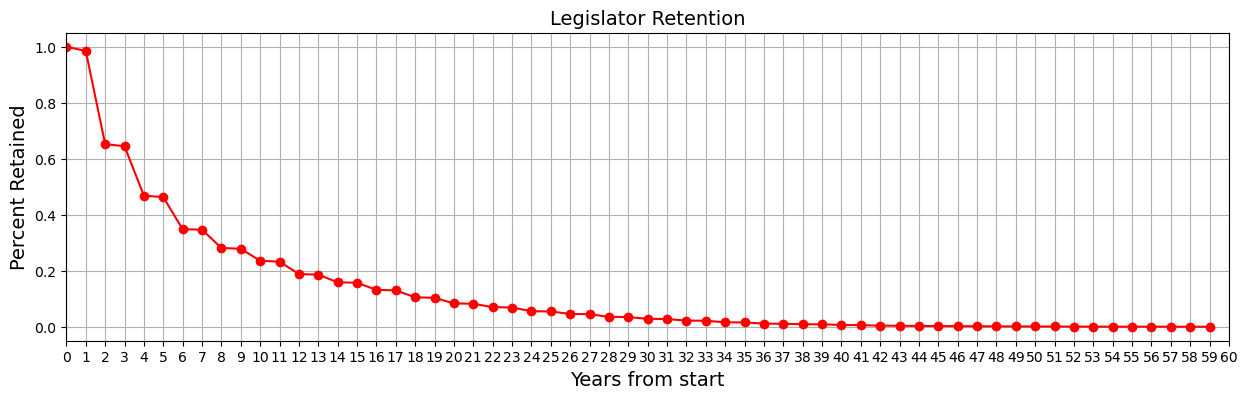

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(15, 4), dpi=100) 

# plot a line graph
plt.plot(df_percent_legislators_retained_by_period['periods'], df_percent_legislators_retained_by_period['pct_retained'], color='red', marker='o')
plt.title('Legislator Retention', fontsize=14)
plt.xlabel('Years from start', fontsize=14)
plt.ylabel('Percent Retained', fontsize=14)


# Scale the y-axis
plt.xlim(0, 60)

# use the 'MultipleLocator' function to set the x-axis ticks every 0.5 units
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))



plt.grid(True)
plt.show()

## 5. Reshaping the data to show it in table format

We can take the cohort retention result and reshape the data to show it in table format. By applying an **aggregate function** with a **CASE statement**, we can pivot and flatten the results.


In [11]:
reshape_percent_legislators_retained_by_period="""
SELECT  
max(case when periods = 0 then pct_retained end) as yr0, 
max(case when periods = 1 then pct_retained end) as yr1, 
max(case when periods = 2 then pct_retained end) as yr2, 
max(case when periods = 3 then pct_retained end) as yr3, 
max(case when periods = 4 then pct_retained end) as yr4, 
max(case when periods = 5 then pct_retained end) as yr5, 
max(case when periods = 6 then pct_retained end) as yr6, 
max(case when periods = 7 then pct_retained end) as yr7, 
max(case when periods = 8 then pct_retained end) as yr8, 
max(case when periods = 9 then pct_retained end) as yr9 
FROM 
df_percent_legislators_retained_by_period 
"""
df_reshape_percent_legislators_retained_by_period = sqldf(reshape_percent_legislators_retained_by_period)
df_reshape_percent_legislators_retained_by_period.head(10)

,yr0,yr1,yr2,yr3,yr4,yr5,yr6,yr7,yr8,yr9
0,1.0,0.984822,0.652341,0.644592,0.468286,0.462933,0.348378,0.346621,0.281275,0.278399


To improve the readability of the percent of legislators retained throughout each time period, we can use a **Seaborn** library's color scale:

Text(0.5, 1.0, 'Percent of legislators retained in each time period')

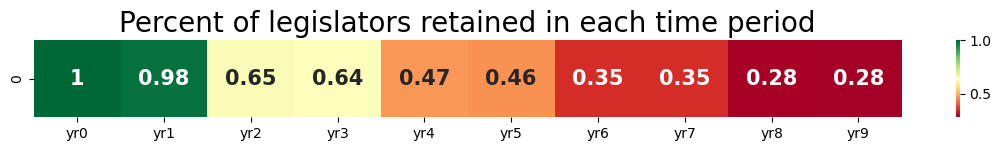

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# https://mode.com/example-gallery/heat-map/
plt.figure(figsize=(14,1))

sns.heatmap(data=df_reshape_percent_legislators_retained_by_period, annot=True, cmap='RdYlGn', 
            annot_kws={"size": 15, 'weight':'bold'})
plt.title('Percent of legislators retained in each time period', fontsize=20)

## 6. Analyzing retention rates across different groups in the cohort analysis

Now that we've calculated a basic retention curve, let's move on to analyzing different groups of legislators. Comparing retention between different groups is one of the main goals of cohort analysis. Next, I'll show you how to form groups based on the time series data and how to form groups using data from other tables.

### 6.1 Retention by Century

In the following example, I will use century cohorts.

The key question we'll be examining is whether the era in which a legislator first took office has any impact on their retention rate. While political trends and public sentiment can change over time, how much of an effect does this have on legislators' retention?

To calculate century cohorts, we first add the century of the first_term calculated previously to the query that finds the period and cohort_retained:

In [13]:
century_cohorts="""
SELECT 
1 + ((strftime('%Y',date(a.first_term)) - 1) / 100) as first_century,
coalesce(cast(strftime('%Y',date(c.date)) - strftime('%Y', a.first_term) as int),0) as periods,

count(distinct a.id_bioguide) as cohort_retained

FROM
(
        SELECT id_bioguide, min(term_start) as first_term
        FROM legislators_terms_DF 
        GROUP BY 1
) a
JOIN legislators_terms_DF b on a.id_bioguide = b.id_bioguide 
LEFT JOIN df_date_dim c on c.date between b.term_start and b.term_end 
and c.MonthName = 'December' and c.DayOfMonth = 31
GROUP BY 1,2"""
df_century_cohorts = sqldf(century_cohorts)
df_century_cohorts.head(10)

,first_century,periods,cohort_retained
0,18,0,368
1,18,1,360
2,18,2,242
3,18,3,233
4,18,4,149
5,18,5,144
6,18,6,99
7,18,7,101
8,18,8,73
9,18,9,70


This query is then used as the subquery, and the cohort_size and pct_retained are calculated in the outer query as previously. In this case, however, we need a PARTITION BY clause that includes first_century so that the first_value is calculated only within the set of rows for that first_century, rather than across the whole result set from the subquery:

In [14]:
percent_legislators_retained_by_yearly_century="""
SELECT 
first_century, 
periods,
first_value(cohort_retained) over (partition by first_century order by periods) as cohort_size,
cohort_retained,
cohort_retained * 1.0 / first_value(cohort_retained) over (partition by first_century order by periods) as pct_retained
FROM
df_century_cohorts aa
ORDER BY 1,2
"""
df_percent_legislators_retained_by_yearly_century = sqldf(percent_legislators_retained_by_yearly_century)
df_percent_legislators_retained_by_yearly_century.head(10)

,first_century,periods,cohort_size,cohort_retained,pct_retained
0,18,0,368,368,1.000000
1,18,1,368,360,0.978261
2,18,2,368,242,0.657609
3,18,3,368,233,0.633152
4,18,4,368,149,0.404891
5,18,5,368,144,0.391304
6,18,6,368,99,0.269022
7,18,7,368,101,0.274457
8,18,8,368,73,0.198370
9,18,9,368,70,0.190217


**Plotting the percent of legislators retained in each Century:**

The results are illustrated in the figure below: a group with a higher curve above the others has a higher retention rate.
It can be observed that retention in the early years has been higher for those who were first elected in the 20th or 21st century. The 21st century is still ongoing, and as a result, many of those legislators have not yet had the chance to remain in office for five or more years, even though they are still included in the denominator. It might be worth considering excluding the 21st century from the analysis, but it has been kept here to demonstrate how the retention curve artificially decreases due to this situation.

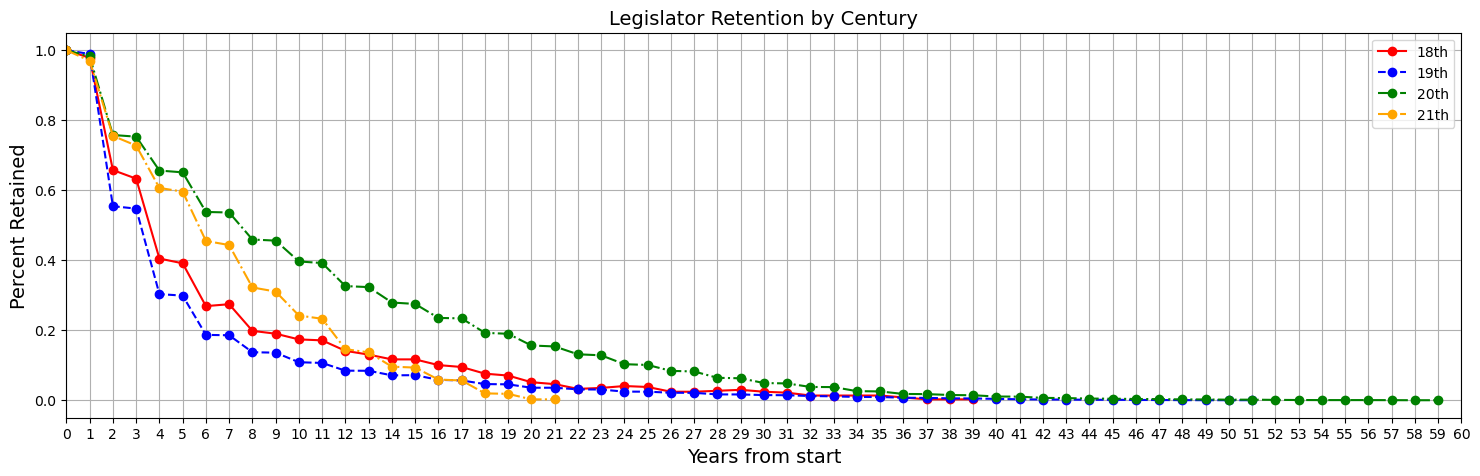

In [15]:
import matplotlib.pyplot as plt
# plot a line graph
import matplotlib.ticker as ticker

fig = plt.figure()

fig.set_figheight(5)
fig.set_figwidth(18)

plt.plot(df_percent_legislators_retained_by_yearly_century['periods'].loc[df_percent_legislators_retained_by_yearly_century['first_century']==18], df_percent_legislators_retained_by_yearly_century['pct_retained'].loc[df_percent_legislators_retained_by_yearly_century['first_century']==18], label='18th',color='red', linestyle="-" , marker='o')
plt.plot(df_percent_legislators_retained_by_yearly_century['periods'].loc[df_percent_legislators_retained_by_yearly_century['first_century']==19], df_percent_legislators_retained_by_yearly_century['pct_retained'].loc[df_percent_legislators_retained_by_yearly_century['first_century']==19], label='19th',color='blue',linestyle="--" , marker='o')
plt.plot(df_percent_legislators_retained_by_yearly_century['periods'].loc[df_percent_legislators_retained_by_yearly_century['first_century']==20], df_percent_legislators_retained_by_yearly_century['pct_retained'].loc[df_percent_legislators_retained_by_yearly_century['first_century']==20], label='20th',color='green',linestyle="-." , marker='o')
plt.plot(df_percent_legislators_retained_by_yearly_century['periods'].loc[df_percent_legislators_retained_by_yearly_century['first_century']==21], df_percent_legislators_retained_by_yearly_century['pct_retained'].loc[df_percent_legislators_retained_by_yearly_century['first_century']==21], label='21th',color='orange',linestyle="-." , marker='o')
plt.title('Legislator Retention by Century', fontsize=14)
plt.xlabel('Years from start', fontsize=14)
plt.ylabel('Percent Retained', fontsize=14)
plt.legend()

# Scale the y-axis
plt.xlim(0, 60)

# use the 'MultipleLocator' function to set the x-axis ticks every 0.5 units
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.grid(True)
plt.show()

**Reshaping the data to show it in table format:**

We can take the cohort retention result by century and reshape the data to show it in table format.

In [16]:
century_reshape_percent_legislators_retained_by_period="""
SELECT 
first_century,
max(case when periods = 0 then pct_retained end) as yr0, 
max(case when periods = 1 then pct_retained end) as yr1, 
max(case when periods = 2 then pct_retained end) as yr2, 
max(case when periods = 3 then pct_retained end) as yr3, 
max(case when periods = 4 then pct_retained end) as yr4, 
max(case when periods = 5 then pct_retained end) as yr5, 
max(case when periods = 6 then pct_retained end) as yr6, 
max(case when periods = 7 then pct_retained end) as yr7, 
max(case when periods = 8 then pct_retained end) as yr8, 
max(case when periods = 9 then pct_retained end) as yr9 
FROM 
df_percent_legislators_retained_by_yearly_century 
group by first_century
"""
df_century_reshape_percent_legislators_retained_by_period = sqldf(century_reshape_percent_legislators_retained_by_period)
df_century_reshape_percent_legislators_retained_by_period.head(10)

,first_century,yr0,yr1,yr2,yr3,yr4,yr5,yr6,yr7,yr8,yr9
0,18,1.0,0.978261,0.657609,0.633152,0.404891,0.391304,0.269022,0.274457,0.198370,0.190217
1,19,1.0,0.989205,0.554374,0.547547,0.303381,0.298936,0.186855,0.185744,0.137323,0.136053
2,20,1.0,0.982125,0.757808,0.753094,0.656256,0.651149,0.538008,0.536437,0.459242,0.456099
3,21,1.0,0.969737,0.755263,0.727632,0.606579,0.596053,0.455263,0.443421,0.322368,0.310526


To improve the readability of the percent of legislators retained throughout each time period, we can use a **Seaborn** library's color scale.

We set the "first_century" column as the index of the DataFrame:

In [17]:
df_century_reshape_percent_legislators_retained_by_period_v2 = df_century_reshape_percent_legislators_retained_by_period.set_index('first_century')
df_century_reshape_percent_legislators_retained_by_period_v2

,yr0,yr1,yr2,yr3,yr4,yr5,yr6,yr7,yr8,yr9
first_century,,,,,,,,,,
18,1.0,0.978261,0.657609,0.633152,0.404891,0.391304,0.269022,0.274457,0.198370,0.190217
19,1.0,0.989205,0.554374,0.547547,0.303381,0.298936,0.186855,0.185744,0.137323,0.136053
20,1.0,0.982125,0.757808,0.753094,0.656256,0.651149,0.538008,0.536437,0.459242,0.456099
21,1.0,0.969737,0.755263,0.727632,0.606579,0.596053,0.455263,0.443421,0.322368,0.310526


Text(0.5, 1.0, 'Percent of legislators retained in each time period by century')

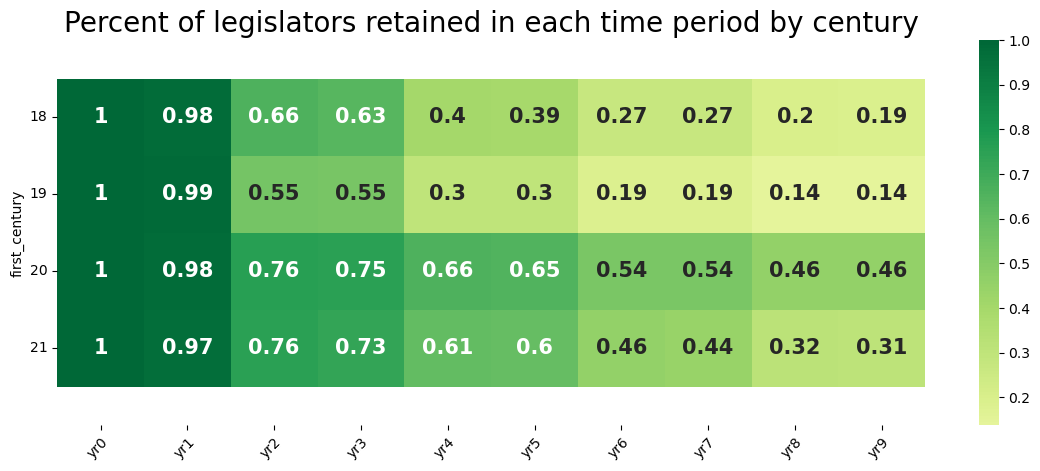

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,5))
ax = sns.heatmap(data=df_century_reshape_percent_legislators_retained_by_period_v2, annot=True, cmap='RdYlGn', 
            annot_kws={"size": 15, 'weight':'bold'}, center=0, robust=True, 
            xticklabels=True, yticklabels=True)
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', rotation_mode='anchor')
plt.title('Percent of legislators retained in each time period by century', fontsize=20)

### 6.2  Retention by State

The legislators_terms table has a state field that shows the state a person represented during their term. By using this field to create cohorts based on the first state representation, we can ensure that individuals who have represented multiple states are only represented once in the data.

When forming cohorts based on attributes that can change over time, it's crucial to assign only one value to each entity to avoid bias in the analysis. This can be achieved by using the value from the earliest record in the dataset to ensure that the entity is not represented in multiple cohorts.

To identify the initial state of each legislator, we can use the first_value window function. To simplify the process and avoid a long GROUP BY clause, we can also convert the min function into a window function."

In [19]:
first_state_for_each_legislator="""
SELECT 
distinct id_bioguide,
min(term_start) over (partition by id_bioguide) as first_term,
first_value(state) over (partition by id_bioguide order by term_start) as first_state
FROM legislators_terms_DF """
df_first_state_for_each_legislator = sqldf(first_state_for_each_legislator)
df_first_state_for_each_legislator.head(10)

,id_bioguide,first_term,first_state
0,A000001,1951-01-03,ND
1,A000002,1947-01-03,VA
2,A000003,1817-12-01,GA
3,A000004,1843-12-04,MA
4,A000005,1887-12-05,TX
5,A000006,1868-01-01,NC
6,A000007,1875-12-06,MA
7,A000008,1857-12-07,ME
8,A000009,1973-01-03,SD
9,A000010,1954-01-01,NE


We can integrate this code with our retention code to calculate retention based on first_state:

In [20]:
percent_legislators_retained_by_state="""
SELECT first_state, periods
,first_value(cohort_retained) over (partition by first_state order by periods) as cohort_size
,cohort_retained
,cohort_retained * 1.0 / 
 first_value(cohort_retained) over (partition by first_state order by periods) as pct_retained
FROM
(
        SELECT a.first_state,
        coalesce(cast(strftime('%Y.%m%d',date(c.date)) - strftime('%Y.%m%d', a.first_term) as int),0) as periods,
        count(distinct a.id_bioguide) as cohort_retained
        FROM
        df_first_state_for_each_legislator a
        JOIN legislators_terms_DF b on a.id_bioguide = b.id_bioguide 
        LEFT JOIN df_date_dim c on c.date between b.term_start and b.term_end 
        and c.MonthName = 'December' and c.DayOfMonth = 31
        GROUP BY 1,2
) aa
ORDER BY 1,2 """
df_percent_legislators_retained_by_state = sqldf(percent_legislators_retained_by_state)
df_percent_legislators_retained_by_state.head(10)

,first_state,periods,cohort_size,cohort_retained,pct_retained
0,AK,0,19,19,1.000000
1,AK,1,19,19,1.000000
2,AK,2,19,15,0.789474
3,AK,3,19,15,0.789474
4,AK,4,19,13,0.684211
5,AK,5,19,13,0.684211
6,AK,6,19,11,0.578947
7,AK,7,19,11,0.578947
8,AK,8,19,10,0.526316
9,AK,9,19,10,0.526316


**Plotting the percent of legislators retained in each State:**

The figure below illustrates the retention curves for the five states with the most legislators. Those elected in Illinois and Massachusetts have the highest retention, while New Yorkers have the lowest retention:

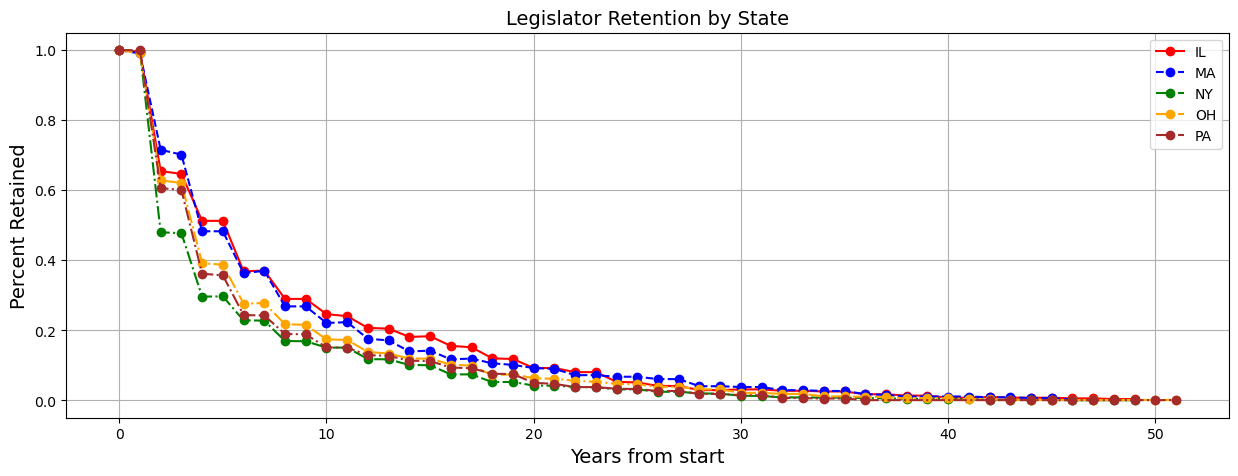

In [21]:
import matplotlib.pyplot as plt
# plot a line graph

fig = plt.figure()

fig.set_figheight(5)
fig.set_figwidth(15)

plt.plot(df_percent_legislators_retained_by_state['periods'].loc[df_percent_legislators_retained_by_state['first_state']=='IL'], df_percent_legislators_retained_by_state['pct_retained'].loc[df_percent_legislators_retained_by_state['first_state']=='IL'], label='IL',color='red', linestyle="-" , marker='o')
plt.plot(df_percent_legislators_retained_by_state['periods'].loc[df_percent_legislators_retained_by_state['first_state']=='MA'], df_percent_legislators_retained_by_state['pct_retained'].loc[df_percent_legislators_retained_by_state['first_state']=='MA'], label='MA',color='blue',linestyle="--" , marker='o')
plt.plot(df_percent_legislators_retained_by_state['periods'].loc[df_percent_legislators_retained_by_state['first_state']=='NY'], df_percent_legislators_retained_by_state['pct_retained'].loc[df_percent_legislators_retained_by_state['first_state']=='NY'], label='NY',color='green',linestyle="-." , marker='o')
plt.plot(df_percent_legislators_retained_by_state['periods'].loc[df_percent_legislators_retained_by_state['first_state']=='OH'], df_percent_legislators_retained_by_state['pct_retained'].loc[df_percent_legislators_retained_by_state['first_state']=='OH'], label='OH',color='orange',linestyle="-." , marker='o')
plt.plot(df_percent_legislators_retained_by_state['periods'].loc[df_percent_legislators_retained_by_state['first_state']=='PA'], df_percent_legislators_retained_by_state['pct_retained'].loc[df_percent_legislators_retained_by_state['first_state']=='PA'], label='PA',color='brown',linestyle="-." , marker='o')
plt.title('Legislator Retention by State', fontsize=14)
plt.xlabel('Years from start', fontsize=14)
plt.ylabel('Percent Retained', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

**Reshaping the data to show it in table format:**

We can take the cohort retention result by state and reshape the data to show it in table format.

In [22]:
state_reshape_percent_legislators_retained_by_period="""
SELECT 
first_state,
max(case when periods = 0 then pct_retained end) as yr0, 
max(case when periods = 1 then pct_retained end) as yr1, 
max(case when periods = 2 then pct_retained end) as yr2, 
max(case when periods = 3 then pct_retained end) as yr3, 
max(case when periods = 4 then pct_retained end) as yr4, 
max(case when periods = 5 then pct_retained end) as yr5, 
max(case when periods = 6 then pct_retained end) as yr6, 
max(case when periods = 7 then pct_retained end) as yr7, 
max(case when periods = 8 then pct_retained end) as yr8, 
max(case when periods = 9 then pct_retained end) as yr9 
FROM 
df_percent_legislators_retained_by_state 
where first_state in ('IL','MA','NY','OH','PA')
group by first_state
"""
df_state_reshape_percent_legislators_retained_by_period = sqldf(state_reshape_percent_legislators_retained_by_period)
df_state_reshape_percent_legislators_retained_by_period.head(10)

,first_state,yr0,yr1,yr2,yr3,yr4,yr5,yr6,yr7,yr8,yr9
0,IL,1.0,0.996055,0.654832,0.646943,0.512821,0.512821,0.368836,0.370809,0.289941,0.289941
1,MA,1.0,0.990971,0.715576,0.702032,0.483070,0.483070,0.363431,0.370203,0.268623,0.268623
2,NY,1.0,0.997317,0.480215,0.477532,0.296445,0.297116,0.228706,0.228035,0.169685,0.169014
3,OH,1.0,0.991354,0.628242,0.621037,0.391931,0.387608,0.276657,0.278098,0.217579,0.216138
4,PA,1.0,1.000000,0.606512,0.600930,0.361860,0.357209,0.243721,0.242791,0.189767,0.188837


To improve the readability of the percent of legislators retained throughout each time period, we can use a Seaborn library's color scale.

We set the "first_state" column as the index of the DataFrame:

In [23]:
df_state_reshape_percent_legislators_retained_by_period_v2 = df_state_reshape_percent_legislators_retained_by_period.set_index('first_state')
df_state_reshape_percent_legislators_retained_by_period_v2

,yr0,yr1,yr2,yr3,yr4,yr5,yr6,yr7,yr8,yr9
first_state,,,,,,,,,,
IL,1.0,0.996055,0.654832,0.646943,0.512821,0.512821,0.368836,0.370809,0.289941,0.289941
MA,1.0,0.990971,0.715576,0.702032,0.483070,0.483070,0.363431,0.370203,0.268623,0.268623
NY,1.0,0.997317,0.480215,0.477532,0.296445,0.297116,0.228706,0.228035,0.169685,0.169014
OH,1.0,0.991354,0.628242,0.621037,0.391931,0.387608,0.276657,0.278098,0.217579,0.216138
PA,1.0,1.000000,0.606512,0.600930,0.361860,0.357209,0.243721,0.242791,0.189767,0.188837


Text(0.5, 1.0, 'Percent of legislators retained in each time period by State')

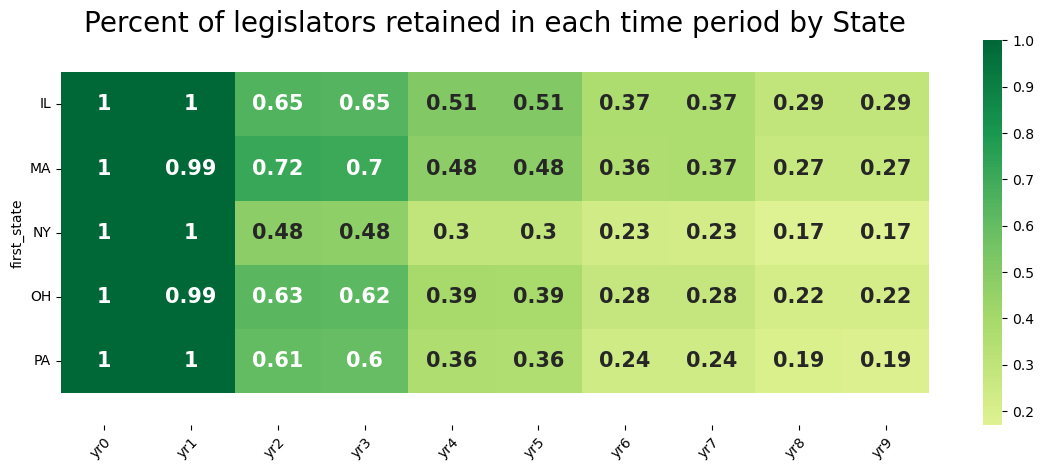

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,5))
ax = sns.heatmap(data=df_state_reshape_percent_legislators_retained_by_period_v2, annot=True, cmap='RdYlGn', 
            annot_kws={"size": 15, 'weight':'bold'}, center=0, robust=True, 
            xticklabels=True, yticklabels=True)
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', rotation_mode='anchor')
plt.title('Percent of legislators retained in each time period by State', fontsize=20)

### 6.3 Retention by Gender
we’ll consider whether the gender of the legislator has any impact on their retention. The legislators_DF table has a "gender" field (F=female, M=male) for categorizing legislators. Join the table as "d" to include gender in calculating "cohort_retained" instead of "year" or "century."

In [25]:
cohort_retained_by_gender="""
SELECT 
d.gender,
coalesce(cast(strftime('%Y',date(c.date)) - strftime('%Y', a.first_term) as int),0) as periods,
count(distinct a.id_bioguide) as cohort_retained

FROM
(
        SELECT id_bioguide, min(term_start) as first_term
        FROM legislators_terms_DF 
        GROUP BY 1
) a
JOIN 
legislators_terms_DF b 

on a.id_bioguide = b.id_bioguide

LEFT JOIN 

df_date_dim c

on c.date between b.term_start and b.term_end 
and c.MonthName = 'December' and c.DayOfMonth = 31

JOIN legislators_DF d 

on a.id_bioguide = d.id_bioguide

GROUP BY 1,2
ORDER BY 2,1
"""
df_cohort_retained_by_gender = sqldf(cohort_retained_by_gender)
df_cohort_retained_by_gender.head(10)

,gender,periods,cohort_retained
0,F,0,366
1,M,0,12152
2,F,1,349
3,M,1,11979
4,F,2,261
5,M,2,7905
6,F,3,256
7,M,3,7813
8,F,4,223
9,M,4,5639


It's evident that a higher number of males have served legislative terms compared to females. Determine "percent_retained" to examine retention between these groups:

In [26]:
percent_retained_by_gender="""
SELECT 
gender, 
periods,
first_value(cohort_retained) over (partition by gender order by periods) as cohort_size,
cohort_retained,
cohort_retained * 1.0 / first_value(cohort_retained) over (partition by gender order by periods) as pct_retained
FROM
df_cohort_retained_by_gender aa
ORDER BY 2,1
"""
df_percent_retained_by_gender = sqldf(percent_retained_by_gender)
df_percent_retained_by_gender.head(10)

,gender,periods,cohort_size,cohort_retained,pct_retained
0,F,0,366,366,1.000000
1,M,0,12152,12152,1.000000
2,F,1,366,349,0.953552
3,M,1,12152,11979,0.985764
4,F,2,366,261,0.713115
5,M,2,12152,7905,0.650510
6,F,3,366,256,0.699454
7,M,3,12152,7813,0.642939
8,F,4,366,223,0.609290
9,M,4,12152,5639,0.464039


**Plotting the percent of legislators retained by Gender:**

The results graphed in the figure below indicate higher retention for female legislators compared to male legislators for periods 2 through 29.

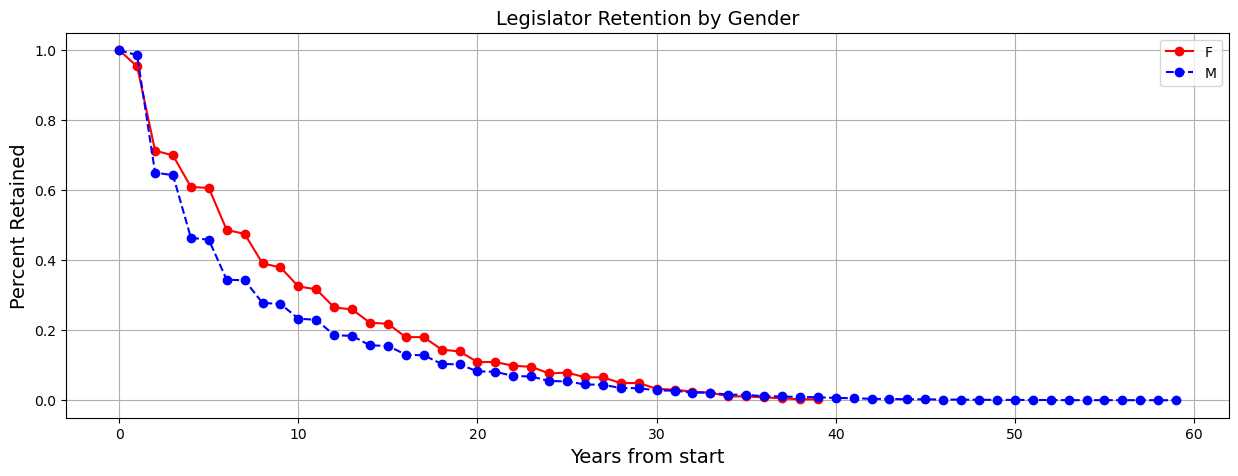

In [27]:
import matplotlib.pyplot as plt
# plot a line graph

fig = plt.figure()

fig.set_figheight(5)
fig.set_figwidth(15)

plt.plot(df_percent_retained_by_gender['periods'].loc[df_percent_retained_by_gender['gender']=='F'], df_percent_retained_by_gender['pct_retained'].loc[df_percent_retained_by_gender['gender']=='F'], label='F',color='red', linestyle="-" , marker='o')
plt.plot(df_percent_retained_by_gender['periods'].loc[df_percent_retained_by_gender['gender']=='M'], df_percent_retained_by_gender['pct_retained'].loc[df_percent_retained_by_gender['gender']=='M'], label='M',color='blue',linestyle="--" , marker='o')

plt.title('Legislator Retention by Gender', fontsize=14)
plt.xlabel('Years from start', fontsize=14)
plt.ylabel('Percent Retained', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

Based on the results presented in the above figure, it is evident that female legislators exhibit higher retention rates compared to their male counterparts during periods 2 through 29. It is worth noting that the first female legislator, Jeannette Rankin, assumed office in 1917 as a Republican representative from Montana. As discussed earlier, retention rates have shown an upward trend in more recent centuries.

To ensure a fair comparison, we can refine the analysis by considering only legislators who initiated their first term after women began serving in Congress. This can be accomplished by incorporating a WHERE clause in the subquery "a" and further restricting the results to individuals who commenced their terms prior to 2000. This ensures that the cohorts included in the analysis have had a minimum of 20 years of tenure in office.

By employing these adjustments, we can obtain a more comprehensive and accurate assessment of retention rates and identify any disparities or advancements in gender representation within the legislative sphere.

In [28]:
cohort_retained_by_gender_1917_1999="""
SELECT 
d.gender,
coalesce(cast(strftime('%Y',date(c.date)) - strftime('%Y', a.first_term) as int),0) as periods,
count(distinct a.id_bioguide) as cohort_retained

FROM
(
        SELECT id_bioguide, min(term_start) as first_term
        FROM legislators_terms_DF 
        GROUP BY 1
) a
JOIN 
legislators_terms_DF 

b on a.id_bioguide = b.id_bioguide

LEFT JOIN 

df_date_dim c

on c.date between b.term_start and b.term_end 
and c.MonthName = 'December' and c.DayOfMonth = 31

JOIN legislators_DF d 

on a.id_bioguide = d.id_bioguide

WHERE a.first_term between '1917-01-01' and '1999-12-31'

GROUP BY 1,2
ORDER BY 2,1
"""
df_cohort_retained_by_gender_1917_1999 = sqldf(cohort_retained_by_gender_1917_1999)
df_cohort_retained_by_gender_1917_1999.head(10)

,gender,periods,cohort_retained
0,F,0,200
1,M,0,3833
2,F,1,187
3,M,1,3769
4,F,2,149
5,M,2,2964
6,F,3,149
7,M,3,2945
8,F,4,129
9,M,4,2625


In [29]:
percent_retained_by_gender_1917_1999="""
SELECT 
gender, 
periods,
first_value(cohort_retained) over (partition by gender order by periods) as cohort_size,
cohort_retained,
cohort_retained * 1.0 / first_value(cohort_retained) over (partition by gender order by periods) as pct_retained
FROM
df_cohort_retained_by_gender_1917_1999 aa
ORDER BY 2,1
"""
df_percent_retained_by_gender_1917_1999 = sqldf(percent_retained_by_gender_1917_1999)
df_percent_retained_by_gender_1917_1999.head(10)

,gender,periods,cohort_size,cohort_retained,pct_retained
0,F,0,200,200,1.000000
1,M,0,3833,3833,1.000000
2,F,1,200,187,0.935000
3,M,1,3833,3769,0.983303
4,F,2,200,149,0.745000
5,M,2,3833,2964,0.773285
6,F,3,200,149,0.745000
7,M,3,3833,2945,0.768328
8,F,4,200,129,0.645000
9,M,4,3833,2625,0.684842


The figure below graphically represents the cohort retention. Although male legislators still hold a majority, the gap between them and female legislators has decreased. As for the revised cohorts, male legislators show better retention till year 7, however, from year 12, female legislators have higher retention rates:

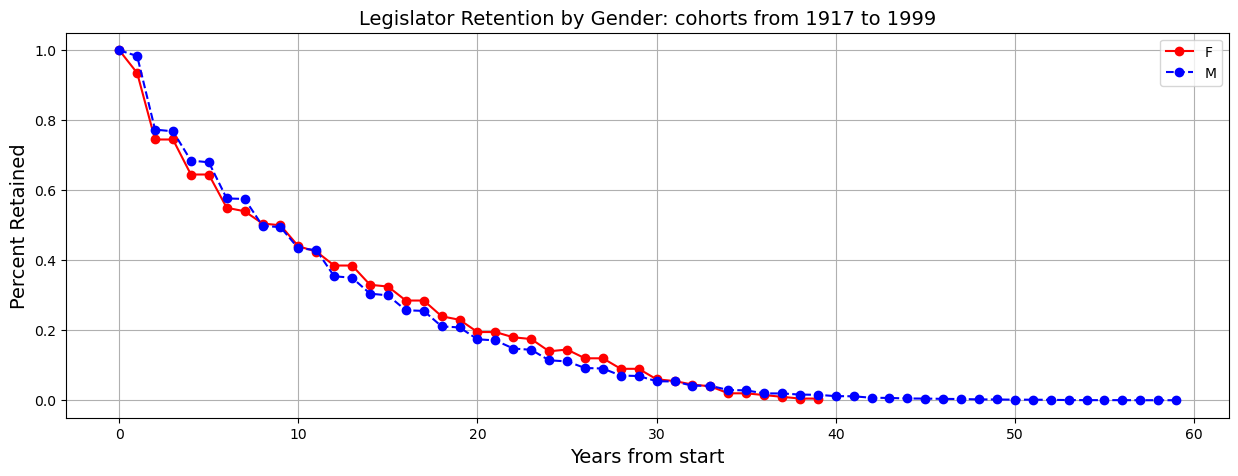

In [30]:
import matplotlib.pyplot as plt
# plot a line graph

fig = plt.figure()

fig.set_figheight(5)
fig.set_figwidth(15)

plt.plot(df_percent_retained_by_gender_1917_1999['periods'].loc[df_percent_retained_by_gender_1917_1999['gender']=='F'], df_percent_retained_by_gender_1917_1999['pct_retained'].loc[df_percent_retained_by_gender_1917_1999['gender']=='F'], label='F',color='red', linestyle="-" , marker='o')
plt.plot(df_percent_retained_by_gender_1917_1999['periods'].loc[df_percent_retained_by_gender_1917_1999['gender']=='M'], df_percent_retained_by_gender_1917_1999['pct_retained'].loc[df_percent_retained_by_gender_1917_1999['gender']=='M'], label='M',color='blue',linestyle="--" , marker='o')

plt.title('Legislator Retention by Gender: cohorts from 1917 to 1999', fontsize=14)
plt.xlabel('Years from start', fontsize=14)
plt.ylabel('Percent Retained', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

**Reshaping the data to show it in table format:**

We can take the cohort retention result by Gender and reshape the data to show it in table format.

In [31]:
gender_reshape_percent_legislators_retained_by_period="""
SELECT 
gender,
max(case when periods = 0 then pct_retained end) as yr0, 
max(case when periods = 1 then pct_retained end) as yr1, 
max(case when periods = 2 then pct_retained end) as yr2, 
max(case when periods = 3 then pct_retained end) as yr3, 
max(case when periods = 4 then pct_retained end) as yr4, 
max(case when periods = 5 then pct_retained end) as yr5, 
max(case when periods = 6 then pct_retained end) as yr6, 
max(case when periods = 7 then pct_retained end) as yr7, 
max(case when periods = 8 then pct_retained end) as yr8, 
max(case when periods = 9 then pct_retained end) as yr9,
max(case when periods = 10 then pct_retained end) as yr10,
max(case when periods = 11 then pct_retained end) as yr11,
max(case when periods = 12 then pct_retained end) as yr12,
max(case when periods = 13 then pct_retained end) as yr13,
max(case when periods = 14 then pct_retained end) as yr14,
max(case when periods = 15 then pct_retained end) as yr15,
max(case when periods = 16 then pct_retained end) as yr16,
max(case when periods = 17 then pct_retained end) as yr17,
max(case when periods = 18 then pct_retained end) as yr18,
max(case when periods = 19 then pct_retained end) as yr19,
max(case when periods = 20 then pct_retained end) as yr20

FROM 
df_percent_retained_by_gender_1917_1999 
group by gender
"""
df_gender_reshape_percent_legislators_retained_by_period = sqldf(gender_reshape_percent_legislators_retained_by_period)
df_gender_reshape_percent_legislators_retained_by_period.head(10)

,gender,yr0,yr1,yr2,yr3,yr4,yr5,yr6,yr7,yr8,...,yr11,yr12,yr13,yr14,yr15,yr16,yr17,yr18,yr19,yr20
0,F,1.0,0.935000,0.745000,0.745000,0.645000,0.645000,0.550000,0.540000,0.505000,...,0.425000,0.385000,0.385000,0.330000,0.325000,0.28500,0.285000,0.240000,0.230000,0.195000
1,M,1.0,0.983303,0.773285,0.768328,0.684842,0.679885,0.576572,0.575267,0.498304,...,0.429429,0.354292,0.350117,0.304722,0.299765,0.25724,0.255414,0.211062,0.208192,0.174276


To improve the readability of the percent of legislators retained throughout each time period, we can use a Seaborn library's color scale.

We set the "gender" column as the index of the DataFrame:

In [32]:
df_gender_reshape_percent_legislators_retained_by_period_v2 = df_gender_reshape_percent_legislators_retained_by_period.set_index('gender')
df_gender_reshape_percent_legislators_retained_by_period_v2

,yr0,yr1,yr2,yr3,yr4,yr5,yr6,yr7,yr8,yr9,...,yr11,yr12,yr13,yr14,yr15,yr16,yr17,yr18,yr19,yr20
gender,,,,,,,,,,,,,,,,,,,,,
F,1.0,0.935000,0.745000,0.745000,0.645000,0.645000,0.550000,0.540000,0.505000,0.500000,...,0.425000,0.385000,0.385000,0.330000,0.325000,0.28500,0.285000,0.240000,0.230000,0.195000
M,1.0,0.983303,0.773285,0.768328,0.684842,0.679885,0.576572,0.575267,0.498304,0.494652,...,0.429429,0.354292,0.350117,0.304722,0.299765,0.25724,0.255414,0.211062,0.208192,0.174276


Text(0.5, 1.0, 'Percent of legislators retained in each time period by Gender')

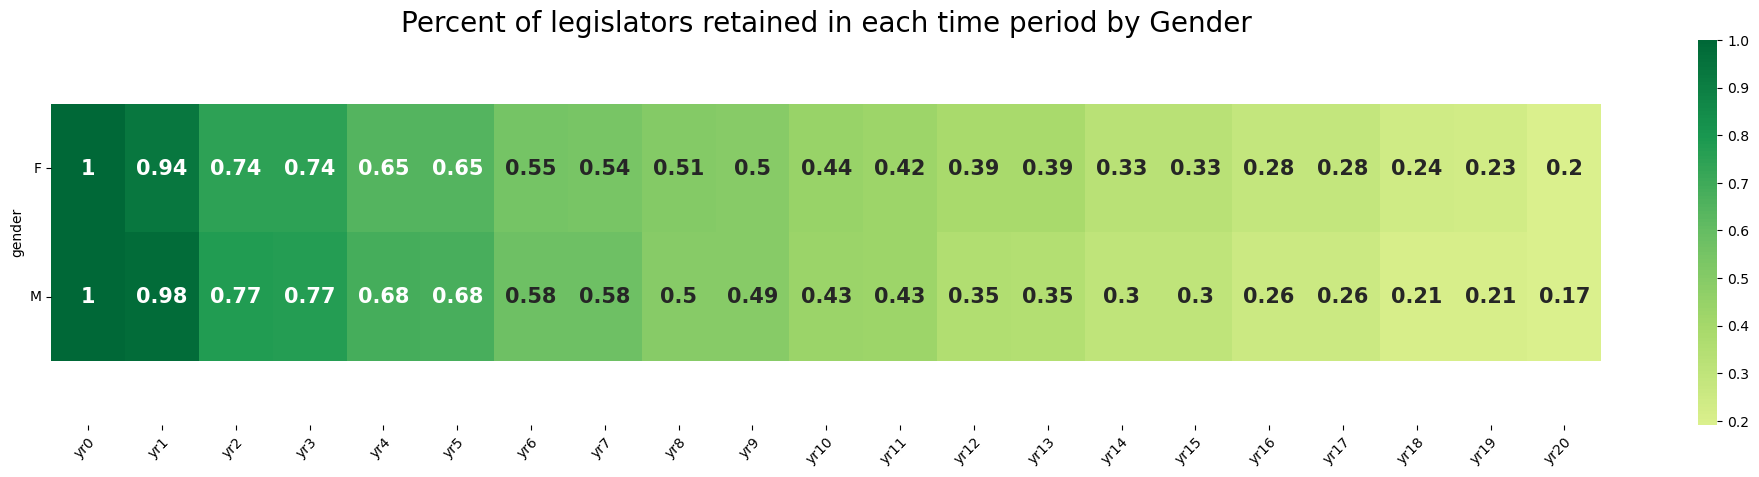

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(25,5))
ax = sns.heatmap(data=df_gender_reshape_percent_legislators_retained_by_period_v2, annot=True, cmap='RdYlGn', 
            annot_kws={"size": 15, 'weight':'bold'}, center=0, robust=True, 
            xticklabels=True, yticklabels=True)
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', rotation_mode='anchor')
plt.title('Percent of legislators retained in each time period by Gender', fontsize=20)

## 7. Conclusions and Insights

The objective of this data science project was to analyze legislator retention rates and identify patterns and trends within the dataset. We examined retention rates by century, state, and gender to gain valuable insights into the behavior of legislators over time.

Analyzing retention rates by century revealed interesting patterns. We observed that a majority of legislators tend to remain in office during the first year, followed by a significant drop-off in the second year as some representatives fail to be reelected. Notably, retention rates were higher for legislators first elected in the 20th or 21st century. However, it's important to note that the 21st century is still ongoing, and many legislators have not had the opportunity to serve for five or more years, which artificially decreases the retention curve.

Examining retention rates by state highlighted variations among different states. Legislators in Illinois and Massachusetts exhibited higher retention rates, while New York had lower retention rates.

Analyzing retention rates by gender revealed a notable disparity, with a higher number of males serving legislative terms compared to females. It is evident that female legislators exhibit higher retention rates compared to their male counterparts during periods 2 through 29. It's worth noting that the first female legislator assumed office in 1917, which was during the late 19th century. Taking into account the analysis of retention rates by century, we observed that retention rates have shown an upward trend in more recent centuries.

To ensure a fair comparison, we can refine the analysis by considering only legislators who initiated their first term after women began serving in Congress and restricting the results to individuals who commenced their terms prior to 2000. This ensures that the cohorts included in the analysis have had a minimum of 20 years of tenure in office.

By employing these adjustments, we can obtain a more comprehensive and accurate assessment of retention rates and identify any disparities or advancements in gender representation within the legislative sphere. These insights contribute to a deeper understanding of legislative dynamics and can inform strategies aimed at promoting equal opportunities and long-term retention for all legislators. Although male legislators still hold a majority, the gap between them and female legislators has decreased. For the revised cohorts, male legislators show better retention rates until year 7; however, from year 12, female legislators have higher retention rates.

In summary, cohort retention analysis proved to be a valuable method for understanding the behavior of entities in a time series dataset. Through SQL calculations and cohort grouping techniques, we gained insights into legislator retention. We explored the use of functions and JOINs to adjust dates and account for sparse cohorts, providing a comprehensive understanding of cohort retention analysis.

By applying these approaches, we were able to draw meaningful insights from the time series data, uncovering trends in legislator retention rates across different dimensions. This analysis has implications for understanding legislative dynamics and can inform strategies for improving retention and representation in public office.